In [33]:
# %load std_libraries.py
# If I make many files here, would be good to do this
import sys
#Indicate operating environment and import core modules
location_input = input("what computer are you on? a = Bens, b = gpucluster, c = other   ")
location_dict = {'a': "C:\\Users\\BMH_work\\github\\expression_broad_data", 'b': "/home/heineike/github/expression_broad_data",'c':'you need to add your location to the location_dict'}
base_dir_rna_seq = location_dict[location_input]
print("rna_seq base directory is " + base_dir_rna_seq)

if sys.path[-1] != base_dir_rna_seq:
    sys.path.append(base_dir_rna_seq)
    print("Added " + base_dir_rna_seq + " to path: " )
    print(sys.path)

import os

print("I am about to import a library")
from core import expression_plots 
from core import io_library 
%load_ext autoreload
%autoreload 2
# %matplotlib 
# plt.ioff()
#%matplotlib inline
%matplotlib notebook

base_dir = os.path.normpath("C:/Users/BMH_work/Google Drive/UCSF/Yeast_colony_drop_seq")
data_processing_dir = base_dir + os.sep + "data" + os.sep
#base_dir + os.sep + os.path.normpath("expression_data") + os.sep

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colorbar as mpl_colorbar
import matplotlib.colors as mpl_colors
#import matplotlib.colormap as cm
#from matplotlib_venn import venn2
import seaborn as sns; sns.set(style="ticks", color_codes=True)
#from sklearn import linear_model
import pickle
#import subprocess
#import networkx as nx
import scipy.stats as stats
#import statsmodels.graphics.gofplots as stats_graph
import scipy.cluster.hierarchy as sch
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import KernelDensity

# from Bio import SeqIO
# from Bio import SeqFeature as sf
# from Bio.SeqRecord import SeqRecord
# from Bio.Alphabet import generic_dna
# from Bio.Seq import Seq

# import re

from collections import Counter
# import scipy.stats as stats
# from itertools import chain
#from itertools import product
#this only works if you are online
online_input = input("are you online? Yes/No")
if online_input == "Yes": 
    import plotly.plotly as py
    import plotly.graph_objs as pygo
    import plotly.tools as pytools
    py.sign_in('heineike02_student','9dMTMZgJMgUP0YX0P5mQ')
    #py.sign_in('heineike02', 'APPjKrtARaN2ZgUYIkqr')
    
# for phylogenetic trees: 
# from ete3 import Tree

#for scraping internet data (e.g. ncbi)
#import requests
#from lxml import etree    #parses xml output

what computer are you on? a = Bens, b = gpucluster, c = other   a
rna_seq base directory is C:\Users\BMH_work\github\expression_broad_data
I am about to import a library
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
are you online? Yes/NoYes


In [80]:
def average_ico_seq_data(ico_count_data, N_scale):
    # 3. Take average for all genes - sum up counts for all colonies, divide by total number of colonies
    print('Making average of all counts')
    ico_count_data_avg = ico_count_data.sum(axis = 1)/ico_count_data.shape[1]

    #4. Normalize by total counts, scale by 10K (the total for the average is about 3300 counts) 
    print('Normalizing average by total counts')

    #Normalize by total counts, and multipy by median of all counts to ensure scale is close to 
    #original counts scale. 
    ico_count_data_avg_norm = ico_count_data_avg.copy()

    ico_count_data_avg_norm = ico_count_data_avg/sum(ico_count_data_avg)*N_scale

    #5. Add a pseudocount. I use 0.1*sum(ARO4_high_exp_genes_avg)*N_scale 
    pseudocount = 0.1/sum(ico_count_data_avg)*N_scale
    print('adding psuedocount of {:0.4f}'.format(pseudocount))
    ico_count_data_avg_norm = ico_count_data_avg_norm + pseudocount
    ico_count_data_avg_norm_log10 = np.log10(ico_count_data_avg_norm)
    
    return ico_count_data_avg_norm, ico_count_data_avg_norm_log10

In [85]:
def process_bulk_seq_data(genes, N_scale, data_processing_dir):
#Load bulk seq data, separate out genes of interest (from high_exp_genes df), normalize and scale using N_scale

    #Loading bulk data
    #Note: changed filenames to have consistent pattern, 
    #replaced CR (\r) with LF (\n), 
    #removed all spaces (there were spaces in front of all gene names)

    bulk_exps = ['colony1', 'colony2', 'culture']
    raw_count_data = {}

    for bulk_exp in bulk_exps: 
        raw_count_data_exp = pd.read_table(data_processing_dir + bulk_exp + '_formatted_extracted_exon_count.txt', header=None,  names = ['sc_genename', bulk_exp], index_col = 0)
        raw_count_data[bulk_exp] = raw_count_data_exp


    bulk_data = pd.concat([raw_count_data[bulk_exp] for bulk_exp in bulk_exps], verify_integrity=True, axis = 1)


    #The bulk experiment data has multiple counts for many rows.  This appears to be because
    #each exon gets its own separate count, but has the same name.  
    #This makes the counts into the sum of all rows with the same name. 

    bulk_data.reset_index(inplace=True)
    grouped = bulk_data.groupby('sc_genename')
    bulk_data_exons_comb = grouped.sum()

    #Update gene names to current SGD names
    ico_seq_synonyms = pd.read_csv(data_processing_dir + os.sep + "ICO_seq_common_name_mismatches.csv")
    ico_seq_synonyms_dict = dict(zip(ico_seq_synonyms['input'],ico_seq_synonyms['symbol']))
    bulk_data_exons_comb.rename(index =ico_seq_synonyms_dict, inplace = True)

    #take out subset of genes that we are analyzing for the ICO seq dataset: 
    bulk_data_subset = bulk_data_exons_comb.loc[(set(genes) & set(bulk_data_exons_comb.index)),:]


    #3. Normalize each colony by total counts

    print('Normalizing bulk data by total counts')

    #Normalize by total counts, and multipy by median of all counts to ensure scale is close to 
    #original counts scale. 
    bulk_data_subset_norm = bulk_data_subset.copy()
    bulk_data_subset_sum = bulk_data_subset.sum()
    med = bulk_data_subset_sum.median()

    for col in bulk_data_subset.columns:
        bulk_data_subset_norm[col] = bulk_data_subset[col]/bulk_data_subset_sum[col]*N_scale


    #sort genes by summed expression
    bulk_data_subset_norm['gene_totals'] = bulk_data_subset_norm.sum(axis=1)
    bulk_data_subset_norm.sort_values('gene_totals',ascending=False, inplace=True)
    bulk_data_subset_norm.drop('gene_totals',axis=1, inplace = True)

    #4. Add a pseudocount. I use 0.1 times 1/the largest number of total counts in any remaining colony,
    # multiplied by the scaling factor N_scale. Thus the pseudocount is 0.1 * the smallest possible value for a single read.
    # The scaling factor is arbitrary, but I used to use the median number of counts in all experiments


    #pseudocount = 0.1/max(bulk_data_ARO4_subset_sum)*med   
    pseudocount = 0.1/max(bulk_data_subset_sum)*N_scale 
    print('adding psuedocount of {:0.4f}'.format(pseudocount))
    bulk_data_subset_norm = bulk_data_subset_norm + pseudocount
    bulk_data_subset_norm_log10 = np.log10(bulk_data_subset_norm)

    return bulk_data_subset_norm, bulk_data_subset_norm_log10

# Goal
Show that by reducing the number of colonies kept, we improve the correspondence between the distributions of the genes from 
bulk data and for individual colonies

## First Figure: 
Observation that Distribution of each cell is very different for the cutoff we are using

## Second Figure:
Pick percentage of genes and show that the distribution remains the same for bulk, avg colony data, and for the top and bottom cell. 

## Third figure: 
Plot R2 or cutoff v.s. N cells and % genes on a grid (heatmap) 

## Make new clusters based on new cutoff

## With chosen cutoff show R2 v.s. both experiments for all three clusters


In [73]:
#Load ICO seq data 

# Load raw data, process, save as .csv  Only need to do once. 

ARO4_lib_data = pd.read_table(data_processing_dir + "out_gene_exon_tagged_2000.dge.txt")
ARO4_lib_data.set_index('GENE', inplace = True)

#Update gene names to current SGD names
ico_seq_synonyms = pd.read_csv(data_processing_dir + "ICO_seq_common_name_mismatches.csv")
ico_seq_synonyms_dict = dict(zip(ico_seq_synonyms['input'],ico_seq_synonyms['symbol']))
ARO4_lib_data.rename(index =ico_seq_synonyms_dict, inplace = True)


#1. Select only colonies containing at least 500 genes that have at least 1 count.  This brings the total number
#   of colonies down to 1642

mincounts = 1 
ngenes = []
thresh_genes = 500
print('Selecting colonies containing data for at least {0:d} genes with at least {1:d} count'.format(thresh_genes, mincounts))


cells_above_thresh = []
for cell in ARO4_lib_data.columns:
    ngenes_gt_mincounts = len(ARO4_lib_data[cell][ARO4_lib_data[cell]>=mincounts])
    ngenes.append(ngenes_gt_mincounts)
    if ngenes_gt_mincounts >=500: 
        cells_above_thresh.append(cell)

ARO4_lib_data_mincount = ARO4_lib_data.loc[:,cells_above_thresh]


#2. Analyze only genes that have at least N=3 counts in one of the smallest M=300 colonies (as determined by total number of reads)
#   This leaves 1064 genes.  
M = 300
lowcount_thresh = 3

print('Selecting genes that have at least {0:d} counts in one of the smallest {1:d} colonies'.format(lowcount_thresh, M))

#Add a row for total counts and sort descending by that row. 
ARO4_lib_data_mincount_total = ARO4_lib_data_mincount.sum()
ARO4_lib_data_mincount_total.name = 'total_counts'
ARO4_lib_data_mincount = ARO4_lib_data_mincount.append(ARO4_lib_data_mincount_total)
ARO4_lib_data_mincount.sort_values(by='total_counts', axis = 1, ascending = False, inplace=True)
ARO4_lib_data_mincount_genes = ARO4_lib_data_mincount.drop('total_counts')

ARO4_high_exp_genes = ARO4_lib_data_mincount_genes[ARO4_lib_data_mincount_genes.iloc[:, -M:].max(axis = 1)>=lowcount_thresh]

#3. Normalize each colony by total counts

print('Normalizing colonies by total counts')

#Normalize by total counts, and multipy by the scaling factor
#The scaling factor for the comparison is the median of the total of all counts over the genes of interest
ARO4_high_exp_genes_norm = ARO4_high_exp_genes.copy()
ARO4_high_exp_genes_sum = ARO4_high_exp_genes.sum()
N_scale = ARO4_high_exp_genes_sum.median()  
for col in ARO4_high_exp_genes.columns:
    ARO4_high_exp_genes_norm[col] = ARO4_high_exp_genes[col]/ARO4_high_exp_genes_sum[col]*N_scale

# #sort genes by summed expression
# ARO4_high_exp_genes_norm['gene_totals'] = ARO4_high_exp_genes_norm.sum(axis=1)
# ARO4_high_exp_genes_norm.sort_values('gene_totals',ascending=False, inplace=True)
# ARO4_high_exp_genes_norm.drop('gene_totals',axis=1, inplace = True)

#4. Add a pseudocount. I use 0.1 times 1/the largest number of total counts in any remaining 
#colony, multiplied by the median number of counts in all colonies so everything is on the same 
#scale.  Thus the pseudocount is 0.1 * the smallest possible value for a single read.
pseudocount = 0.1/ARO4_high_exp_genes_sum[0]*N_scale  ## I feel like I should just use min(ARO4_high_exp_genes_sum) rather than the first entry, relying on the sort
print('adding psuedocount of {:0.4f}'.format(pseudocount))
ARO4_high_exp_genes_norm = ARO4_high_exp_genes_norm + pseudocount
ARO4_high_exp_genes_norm_log10 = np.log10(ARO4_high_exp_genes_norm)

#ARO4_high_exp_genes_norm_log10.to_csv(data_processing_dir + 'ARO4_high_exp_genes_norm_log10.csv')
#ARO4_high_exp_genes_norm.to_csv(data_processing_dir + 'ARO4_high_exp_genes_norm.csv')



Selecting colonies containing data for at least 500 genes with at least 1 count
Selecting genes that have at least 3 counts in one of the smallest 300 colonies
Normalizing colonies by total counts
adding psuedocount of 0.0089


In [74]:
#Create Average ico_seq datagiven the high exp_genes set and N_scale: 

# 3. Take average for all genes - sum up counts for all colonies, divide by total number of colonies
print('Making average of all counts')
ARO4_high_exp_genes_avg = ARO4_high_exp_genes.sum(axis = 1)/ARO4_high_exp_genes.shape[1]

#4. Normalize by total counts, scale by 10K (the total for the average is about 3300 counts) 
print('Normalizing average by total counts')

#Normalize by total counts, and multipy by median of all counts to ensure scale is close to 
#original counts scale. 
ARO4_high_exp_genes_avg_norm = ARO4_high_exp_genes_avg.copy()

ARO4_high_exp_genes_avg_norm = ARO4_high_exp_genes_avg_norm/sum(ARO4_high_exp_genes_avg)*N_scale

#5. Add a pseudocount. I use 0.1*sum(ARO4_high_exp_genes_avg)*N_scale 
pseudocount = 0.1/sum(ARO4_high_exp_genes_avg)*N_scale
print('adding psuedocount of {:0.4f}'.format(pseudocount))
ARO4_high_exp_genes_avg_norm = ARO4_high_exp_genes_avg_norm + pseudocount
ARO4_high_exp_genes_avg_norm_log10 = np.log10(ARO4_high_exp_genes_avg_norm)

# ARO4_high_exp_genes_norm_log10.to_csv(data_processing_dir + 'ARO4_high_exp_genes_norm_log10.csv')
# ARO4_high_exp_genes_norm.to_csv(data_processing_dir + 'ARO4_high_exp_genes_norm.csv')

Making average of all counts
Normalizing average by total counts
adding psuedocount of 0.0712


In [75]:
#Load bulk seq data, separate out genes of interest (from high_exp_genes df), normalize and scale using N_scale

#Loading bulk data
#Note: changed filenames to have consistent pattern, 
#replaced CR (\r) with LF (\n), 
#removed all spaces (there were spaces in front of all gene names)

bulk_exps = ['colony1', 'colony2', 'culture']
raw_count_data = {}

for bulk_exp in bulk_exps: 
    raw_count_data_exp = pd.read_table(data_processing_dir + bulk_exp + '_formatted_extracted_exon_count.txt', header=None,  names = ['sc_genename', bulk_exp], index_col = 0)
    raw_count_data[bulk_exp] = raw_count_data_exp


bulk_data = pd.concat([raw_count_data[bulk_exp] for bulk_exp in bulk_exps], verify_integrity=True, axis = 1)


#The bulk experiment data has multiple counts for many rows.  This appears to be because
#each exon gets its own separate count, but has the same name.  
#This makes the counts into the sum of all rows with the same name. 

bulk_data.reset_index(inplace=True)
grouped = bulk_data.groupby('sc_genename')
bulk_data_exons_comb = grouped.sum()

#Update gene names to current SGD names
ico_seq_synonyms = pd.read_csv(data_processing_dir + os.sep + "ICO_seq_common_name_mismatches.csv")
ico_seq_synonyms_dict = dict(zip(ico_seq_synonyms['input'],ico_seq_synonyms['symbol']))
bulk_data_exons_comb.rename(index =ico_seq_synonyms_dict, inplace = True)

#take out subset of genes that we are analyzing for the ICO seq dataset: 
bulk_data_ARO4_subset = bulk_data_exons_comb.loc[(set(ARO4_high_exp_genes.index) & set(bulk_data_exons_comb.index)),:]


#3. Normalize each colony by total counts

print('Normalizing bulk data by total counts')

#Normalize by total counts, and multipy by median of all counts to ensure scale is close to 
#original counts scale. 
bulk_data_ARO4_subset_norm = bulk_data_ARO4_subset.copy()
bulk_data_ARO4_subset_sum = bulk_data_ARO4_subset.sum()
med = bulk_data_ARO4_subset_sum.median()

for col in bulk_data_ARO4_subset.columns:
    bulk_data_ARO4_subset_norm[col] = bulk_data_ARO4_subset[col]/bulk_data_ARO4_subset_sum[col]*N_scale


#sort genes by summed expression
bulk_data_ARO4_subset_norm['gene_totals'] = bulk_data_ARO4_subset_norm.sum(axis=1)
bulk_data_ARO4_subset_norm.sort_values('gene_totals',ascending=False, inplace=True)
bulk_data_ARO4_subset_norm.drop('gene_totals',axis=1, inplace = True)

#4. Add a pseudocount. I use 0.1 times 1/the largest number of total counts in any remaining colony,
# multiplied by the scaling factor N_scale. Thus the pseudocount is 0.1 * the smallest possible value for a single read.
# The scaling factor is arbitrary, but I used to use the median number of counts in all experiments


#pseudocount = 0.1/max(bulk_data_ARO4_subset_sum)*med   
pseudocount = 0.1/max(bulk_data_ARO4_subset_sum)*N_scale 
print('adding psuedocount of {:0.4f}'.format(pseudocount))
bulk_data_ARO4_subset_norm = bulk_data_ARO4_subset_norm + pseudocount
bulk_data_ARO4_subset_norm_log10 = np.log10(bulk_data_ARO4_subset_norm)



Normalizing bulk data by total counts
adding psuedocount of 0.0001


In [76]:
#Merge bulk and avg ico_seq data
bulk_data_ico_avg = bulk_data_ARO4_subset_norm_log10.merge(pd.DataFrame(ARO4_high_exp_genes_avg_norm_log10, columns = ['ico_seq_avg']), how = 'inner', left_index=True, right_index=True)
bulk_data_ico_avg['colony'] = bulk_data_ico_avg.loc[:,['colony1','colony2']].mean(axis=1)


<IPython.core.display.Javascript object>


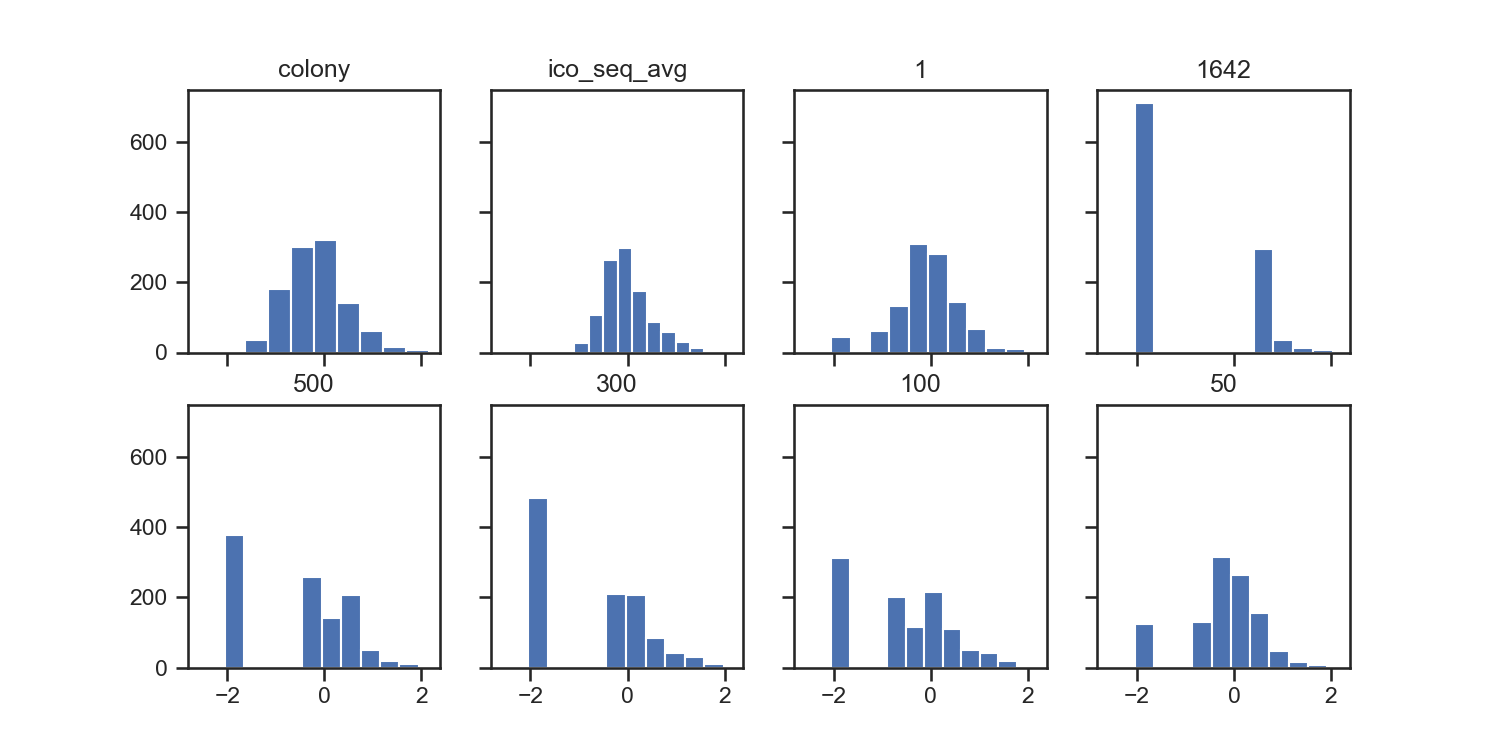

In [77]:
#Distributions bulk, avg and individual cells

fig, axarr = plt.subplots(2,4, sharex=True, sharey = True, figsize = (10,5))

jj = 0

X_plot = np.linspace(-2.5, 2.5, 1000)[:, np.newaxis]

for dataset in ['colony','ico_seq_avg']: 
    data = bulk_data_ico_avg[dataset]
    ax = axarr[np.unravel_index(jj,axarr.shape)]
    ax.hist(data,bins=10)
#     kde = KernelDensity(kernel='tophat', bandwidth=0.75).fit(np.array(data)[:,np.newaxis])
#     log_dens = kde.score_samples(X_plot)
#     ax.fill(X_plot[:, 0], np.exp(log_dens), fc='#AAAAFF')
    ax.set_title(dataset)
    jj = jj + 1
    
cell_nos = [0,ARO4_high_exp_genes_norm_log10.shape[1]-1,499,299,99,49]

for cell_no in cell_nos: 
    ax = axarr[np.unravel_index(jj,axarr.shape)]
    data = ARO4_high_exp_genes_norm_log10.iloc[:,cell_no]
    ax.hist(data,bins=10)
#     kde = KernelDensity(kernel='tophat', bandwidth=0.75).fit(np.array(data)[:,np.newaxis])
#     log_dens = kde.score_samples(X_plot)
#     ax.fill(X_plot[:, 0], np.exp(log_dens), fc='#AAAAFF')
    ax.set_title(str(cell_no + 1))
    jj = jj+1


Distribution of normalized log expression values for the 1064 genes analyzed for the bulk colony experiment, the average of all ico-seq colonies, and for various individual colonies in the 1642 colonies that were analyzed (Colony number 1 had the highest total number of reads, 1642 had the lowest total number of reads).  The bar on the left for the individual colonies represents genes that had zero counts (which gave a -2 value given the pseudocount after normalizing and taking a log10 transform).  We see that the top half of the distribution for individual cells resembles the top half of the distribution for all cells.  

The histogram for the average is not that different from the histogram for the bulk data. 

I was concerned that the average counts would be thrown off by the fact that a lot of the lower expression genes have zero values in a lot of the cells because of the small number of reads (so the distribution would end up having a fat tail).  This may be the case, but it is hard to tell).  

At any rate, this makes me worried that colonies with lower total read counts will cluster together artificially because they will exclusively contain only the most highly expressed genes.  It makes me want to only analyze the most highly expressed genes in colonies with enough reads so that the distribution of expression for those genes that are analyzed in a single colony looks like the distribution of expression for those same genes in a bulk dataset.  

In [ ]:
#Pick the top pct_thresh = 50% of genes based on the average ICOseq data
pct_thresh = 0.5
top_genes = ARO4_high_exp_genes_avg_norm_log10.sort_values()[int(len(ARO4_high_exp_genes_avg_norm_log10)*(1-pct_thresh)):].index

In [65]:
range(500)

range(0, 500)

In [79]:
#Rebuild data sets based on those genes: 

#Load ICO seq data 

# # Load raw data, process, save as .csv  Only need to do once. 

# ARO4_lib_data = pd.read_table(data_processing_dir + "out_gene_exon_tagged_2000.dge.txt")
# ARO4_lib_data.set_index('GENE', inplace = True)

# #Update gene names to current SGD names
# ico_seq_synonyms = pd.read_csv(data_processing_dir + "ICO_seq_common_name_mismatches.csv")
# ico_seq_synonyms_dict = dict(zip(ico_seq_synonyms['input'],ico_seq_synonyms['symbol']))
# ARO4_lib_data.rename(index =ico_seq_synonyms_dict, inplace = True)

#1. Select only the genes of interest: 

ARO4_top_genes = ARO4_lib_data.loc[top_genes, :]

#2. Select the colonies with the top N total genes (for that set)

topN = 500

#Add a row for total counts and sort descending by that row. 
ARO4_top_genes_total = ARO4_top_genes.sum()
ARO4_top_genes_total.name = 'total_counts'
ARO4_top_genes = ARO4_top_genes.append(ARO4_top_genes_total)
ARO4_top_genes.sort_values(by='total_counts', axis = 1, ascending = False, inplace=True)
ARO4_top_genes = ARO4_top_genes.drop('total_counts')

ARO4_top_genes_colonies = ARO4_top_genes.iloc[:,range(0,topN)]

#3. Normalize each colony by total counts
print('Normalizing colonies by total counts')

#Normalize by total counts, and multipy by the scaling factor
#The scaling factor for the comparison is the median of the total of all counts over the genes of interest
ARO4_top_genes_colonies_norm = ARO4_top_genes_colonies.copy()
ARO4_top_genes_colonies_sum = ARO4_top_genes_colonies.sum()
N_scale = ARO4_top_genes_colonies_sum.median()  
for col in ARO4_top_genes_colonies.columns:
    ARO4_top_genes_colonies_norm[col] = ARO4_top_genes_colonies[col]/ARO4_top_genes_colonies_sum[col]*N_scale

# #sort genes by summed expression
# ARO4_top_genes_colonies_norm['gene_totals'] = ARO4_top_genes_colonies_norm.sum(axis=1)
# ARO4_top_genes_colonies_norm.sort_values('gene_totals',ascending=False, inplace=True)
# ARO4_top_genes_colonies_norm.drop('gene_totals',axis=1, inplace = True)

#4. Add a pseudocount. I use 0.1 times 1/the largest number of total counts in any remaining 
#colony, multiplied by the median number of counts in all colonies so everything is on the same 
#scale.  Thus the pseudocount is 0.1 * the smallest possible value for a single read.
pseudocount = 0.1/ARO4_top_genes_colonies_sum[0]*N_scale   ## I feel like I should just use min(ARO4_high_exp_genes_sum) rather than the first entry, relying on the sort
print('adding psuedocount of {:0.4f}'.format(pseudocount))
ARO4_top_genes_colonies_norm = ARO4_top_genes_colonies_norm + pseudocount
ARO4_top_genes_colonies_norm_log10 = np.log10(ARO4_top_genes_colonies_norm)

#ARO4_high_exp_genes_norm_log10.to_csv(data_processing_dir + 'ARO4_high_exp_genes_norm_log10.csv')
#ARO4_high_exp_genes_norm.to_csv(data_processing_dir + 'ARO4_high_exp_genes_norm.csv')



Normalizing colonies by total counts
adding psuedocount of 0.0192


In [81]:
#Create Average ico_seq datagiven the high exp_genes set and N_scale: 

ARO4_top_genes_colonies_avg_norm, ARO4_top_genes_colonies_avg_norm_log10 = average_ico_seq_data(ARO4_top_genes_colonies, N_scale)


Making average of all counts
Normalizing average by total counts
adding psuedocount of 0.0790


In [86]:
#Load and process bulk data
bulk_data_top_genes_colonies_norm, bulk_data_top_genes_colonies_norm_log10 = process_bulk_seq_data(ARO4_top_genes_colonies_avg_norm_log10.index, N_scale, data_processing_dir)


Normalizing bulk data by total counts
adding psuedocount of 0.0003


In [88]:
#Merge bulk and avg ico_seq data
bulk_data_ico_avg_top = bulk_data_top_genes_colonies_norm_log10.merge(pd.DataFrame(ARO4_top_genes_colonies_avg_norm_log10, columns = ['ico_seq_avg']), how = 'inner', left_index=True, right_index=True)
bulk_data_ico_avg_top['colony'] = bulk_data_ico_avg.loc[:,['colony1','colony2']].mean(axis=1)



<IPython.core.display.Javascript object>


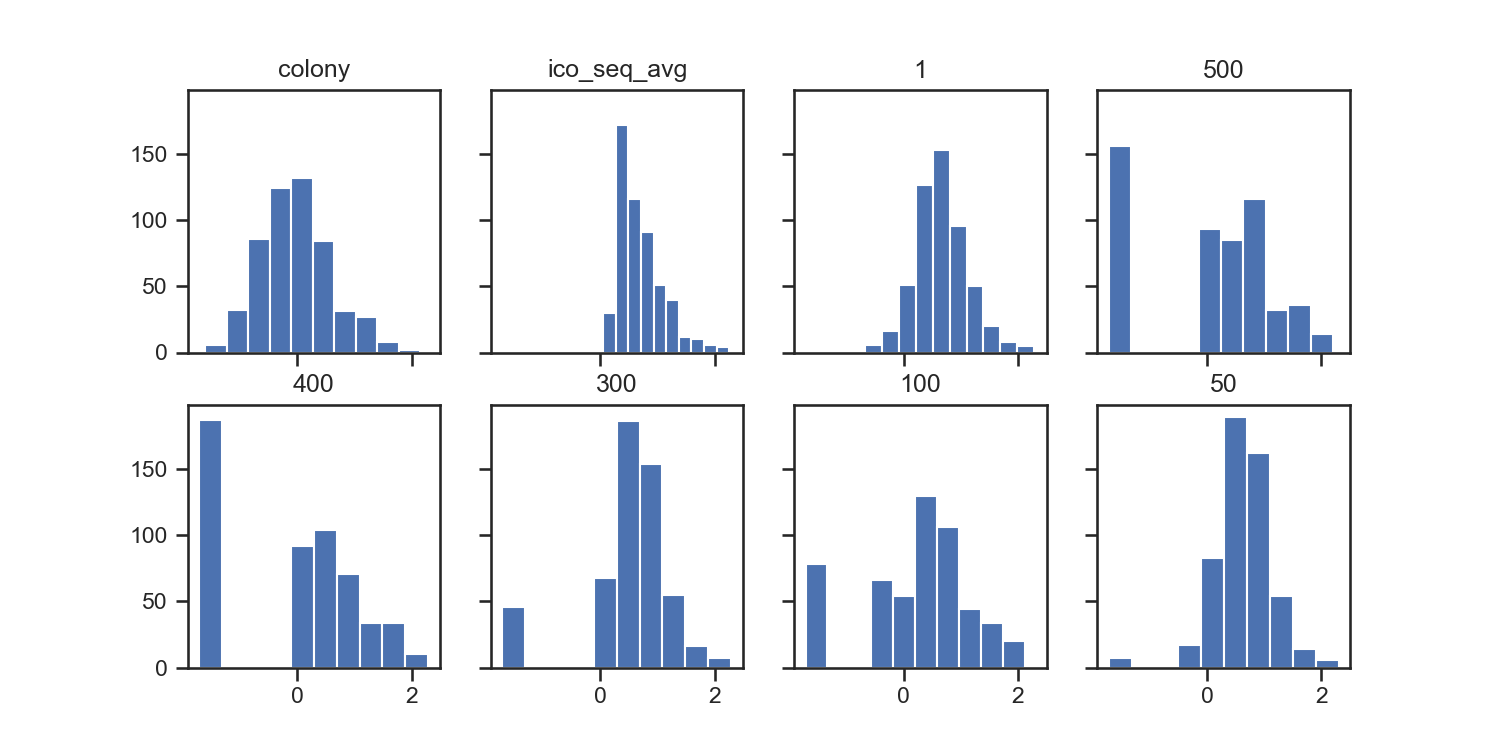

In [89]:
#Distributions bulk, avg and individual cells

fig, axarr = plt.subplots(2,4, sharex=True, sharey = True, figsize = (10,5))

jj = 0

X_plot = np.linspace(-2.5, 2.5, 1000)[:, np.newaxis]

for dataset in ['colony','ico_seq_avg']: 
    data = bulk_data_ico_avg_top[dataset]
    ax = axarr[np.unravel_index(jj,axarr.shape)]
    ax.hist(data,bins=10)
#     kde = KernelDensity(kernel='tophat', bandwidth=0.75).fit(np.array(data)[:,np.newaxis])
#     log_dens = kde.score_samples(X_plot)
#     ax.fill(X_plot[:, 0], np.exp(log_dens), fc='#AAAAFF')
    ax.set_title(dataset)
    jj = jj + 1
    
cell_nos = [0,ARO4_top_genes_colonies_norm_log10.shape[1]-1,399,299,99,49]

for cell_no in cell_nos: 
    ax = axarr[np.unravel_index(jj,axarr.shape)]
    data = ARO4_top_genes_colonies_norm_log10.iloc[:,cell_no]
    ax.hist(data,bins=10)
#     kde = KernelDensity(kernel='tophat', bandwidth=0.75).fit(np.array(data)[:,np.newaxis])
#     log_dens = kde.score_samples(X_plot)
#     ax.fill(X_plot[:, 0], np.exp(log_dens), fc='#AAAAFF')
    ax.set_title(str(cell_no + 1))
    jj = jj+1

<IPython.core.display.Javascript object>


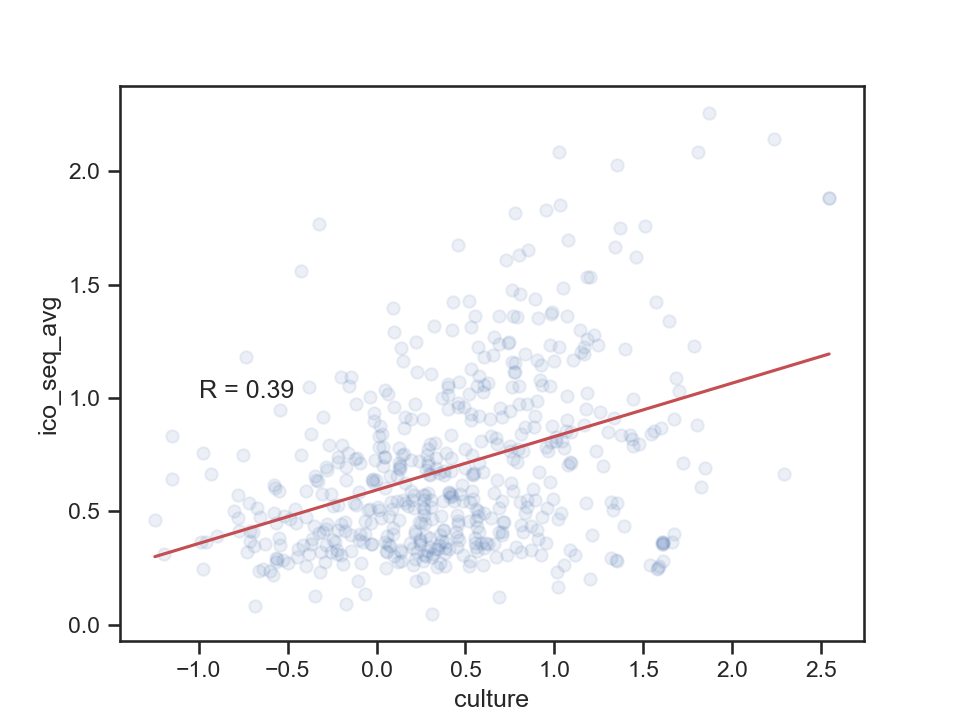

0.23589306254235748
0.5940852147775754


Text(0,0.5,'ico_seq_avg')

In [93]:
fix, ax = plt.subplots()
xcond = 'culture'
ycond = 'ico_seq_avg'
xvalues =  bulk_data_ico_avg_top[xcond]
yvalues =  bulk_data_ico_avg_top[ycond]
slope, intercept, r_value, p_value, std_err = stats.linregress(xvalues, yvalues)
print(slope)
print(intercept)
ax.scatter(xvalues,yvalues, alpha = 0.1)
minx = min(xvalues)
maxx = max(xvalues)
line_xvals = np.linspace(minx,maxx, num=4)
line_yvals = intercept + slope*line_xvals
ax.plot(line_xvals, line_yvals, 'r')
ax.text(-1, 1.0, 'R = {:.2f}'.format(r_value))
ax.set_xlabel(xcond)
ax.set_ylabel(ycond)
